# Regularization and Multi Classes Classification

## Dataset

Loading the Iris dataset from scikit-learn. Here, the third column represents the petal length, and the fourth column the petal width of the flower examples. The classes are already converted to integer labels where 0=Iris-Setosa, 1=Iris-Versicolor, 2=Iris-Virginica.

In [4]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


Splitting data into 70% training and 30% test data:

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [7]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


Standardizing the features:

In [9]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [10]:
X_train_std.shape

(105, 2)

In [11]:
X_test_std.shape

(45, 2)

## Training a logistic regression model with scikit-learn

In [13]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='none',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='Test set')      

Training a logistic regression model using the standardized training data:

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

"""
Since there are 3 different classes in the dataset, we need to use OneVsRestClassifier
https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
One-vs-the-rest (OvR) multiclass strategy.
Also known as one-vs-all, this strategy consists in fitting one classifier per class. 
For each classifier, the class is fitted against all the other classes. 
In addition to its computational efficiency (only n_classes classifiers are needed), 
one advantage of this approach is its interpretability. 
Since each class is represented by one and one classifier only, 
it is possible to gain knowledge about the class by inspecting its corresponding classifier. 
This is the most commonly used strategy for multiclass classification and is a fair default choice.
OneVsRestClassifier can also be used for multilabel classification. 
"""
lr = OneVsRestClassifier(LogisticRegression())
lr.fit(X_train_std, y_train)

OneVsRestClassifier(estimator=LogisticRegression())

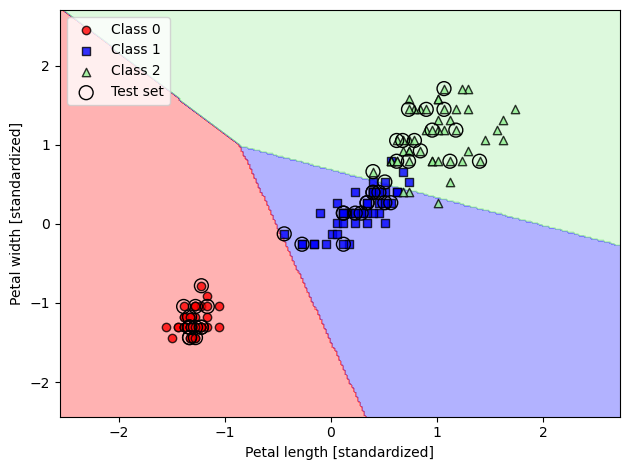

In [16]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('figures/03_06.png', dpi=300)
plt.show()

In [17]:
lr.predict_proba(X_test_std[:3, :])

array([[4.35424381e-04, 2.40133856e-01, 7.59430720e-01],
       [7.98498914e-01, 2.01272655e-01, 2.28430822e-04],
       [8.15960440e-01, 1.83929887e-01, 1.09672897e-04]])

In [18]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1) ## summing across columns for each row.

array([1., 1., 1.])

In [19]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1) ## returns the index of the column that contains the maximum value.

array([2, 0, 0])

In [20]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [21]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

## Tackling overfitting via regularization

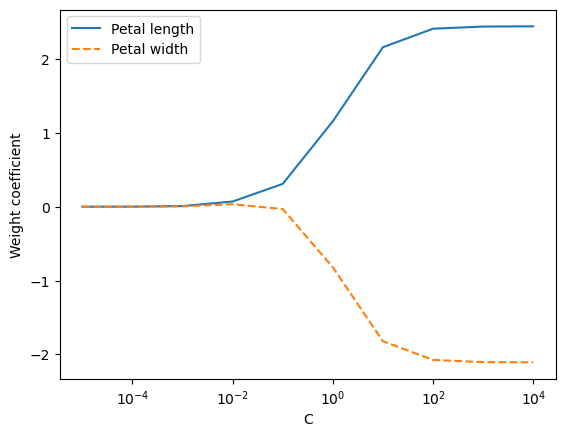

In [23]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = OneVsRestClassifier(LogisticRegression(C=10.**c))
    lr.fit(X_train_std, y_train)
    weights.append(lr.estimators_[1].coef_[0])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='Petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='Petal width')
plt.ylabel('Weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()